**Step 1: Load yass**

In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import progressbar
import matplotlib.pyplot as plt
import logging
import scipy.io as sio
import yass
from yass import read_config
from yass import preprocess
from yass.augment import make_training_data, save_detect_network_params, save_triage_network_params, save_ae_network_params
from yass.augment import train_detector, train_ae, train_triage
import matplotlib.pyplot as plt


**Step 2: Read Configuration File**

In [2]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

**Step 2.1: Preprocessing (optional)**

Make sure the standarized data exists. Otherwise, run this step to automatically generate a temp folder including the standarized and filtered data.

In [3]:
_ = preprocess.run()

**Step 3: Load Spike Train**

To train the Neural Network, you need to have a recording with sorted result. The result does not need to be perfect.
If you don't have any sorting result yet, you can run yass with threshold detection option. In your configuration file, set spikes.detection = threshold.

spike_train is a matrix of size (number of spikes x 2). Each row represents an individual spike. The first column is the spike time (not in milliseconds or seconds but in actual temporal location in recording). The second column is the spike ID.

Other python functions can be used to load the data depending on the data type. For example, use the following code for loading the binary data: 

f = open('location/to/spiketrain', 'r')

spike_train= np.fromfile(f, dtype)

In [4]:
spike_train = np.load("/ssd/data/eduardo/threshold_49/spike_train.npy") 

In [5]:
spike_train = np.hstack((spike_train, np.ones((spike_train.shape[0], 1), 'int32')))

**Step 3.2: Visually Inspect Templates (optional)**

Not necessarily all the templates generated from the groundtruth look good. It is advised that user visually inspect these templates one by one and only keep good templates, i.e. isolated spikes with enough absolute amplitude (usually >= 3 standard units).

In [6]:
from yass.templates.util import get_templates
from yass.augment.crop import crop_templates

#if the standardized data is elsewhere, replace the following path accordingly
path_to_data = os.path.join(CONFIG.data.root_folder, 'tmp/preprocess/standarized.bin') 

templates, _ = get_templates(spike_train, path_to_data, '100MB', 4*CONFIG.spike_size)
templates = np.transpose(templates, (2, 1, 0))
templates = crop_templates(templates, CONFIG.spike_size,
                           CONFIG.neigh_channels, CONFIG.geom)

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


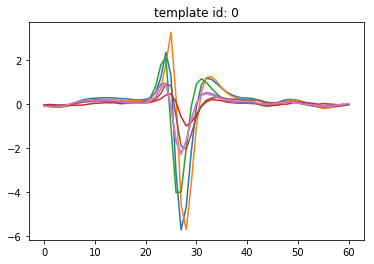

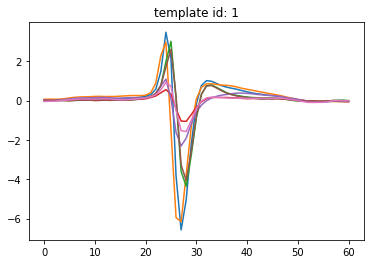

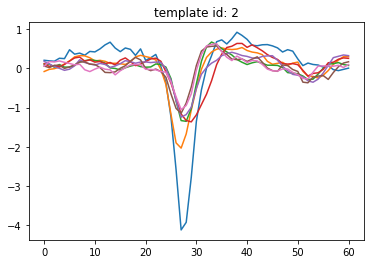

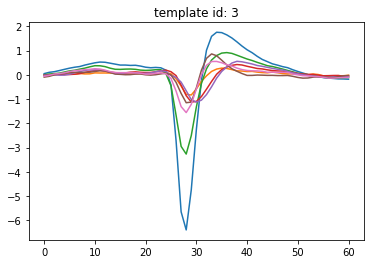

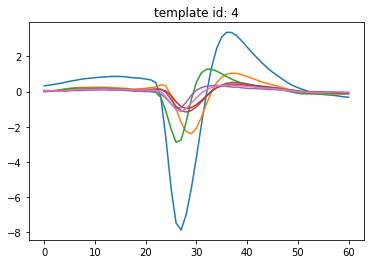

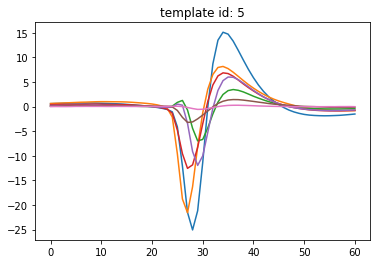

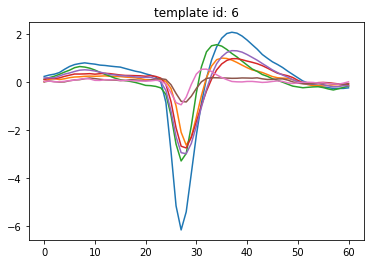

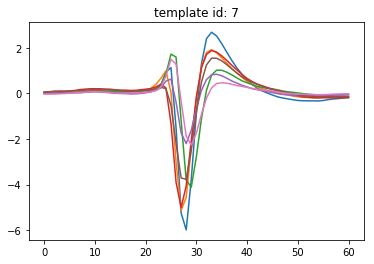

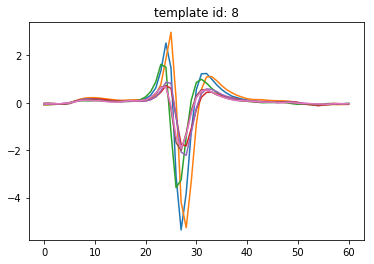

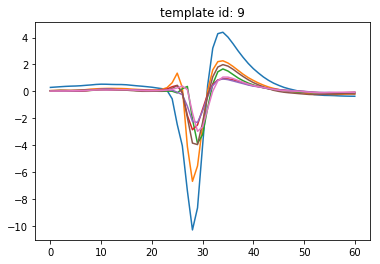

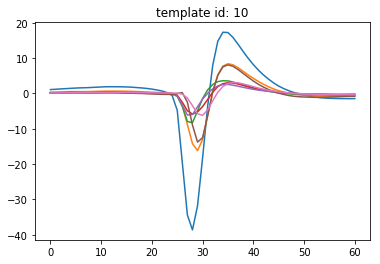

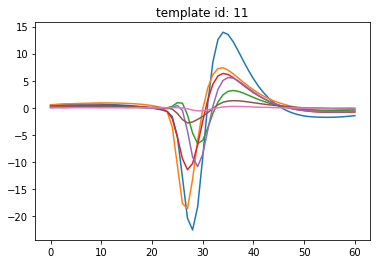

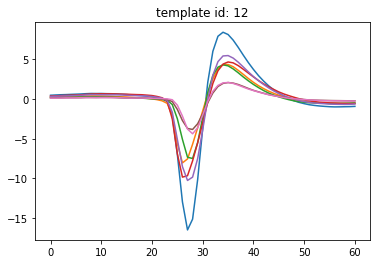

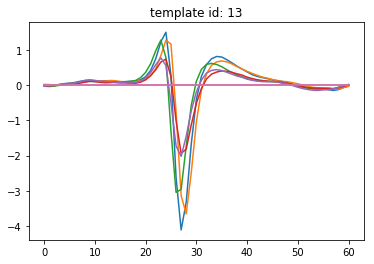

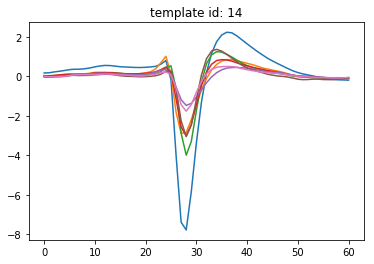

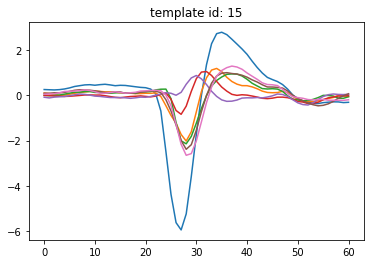

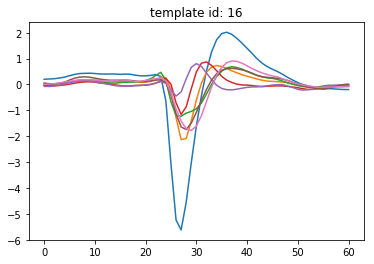

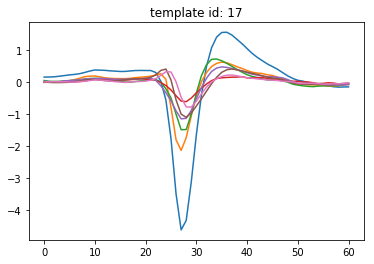

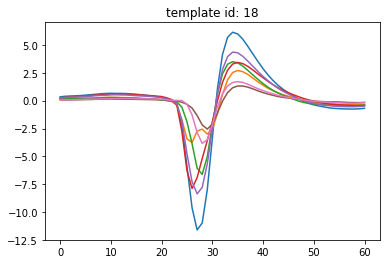

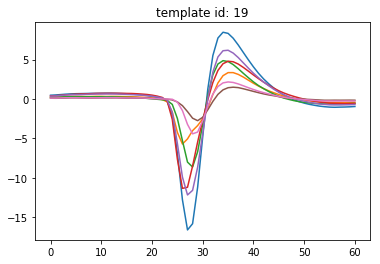

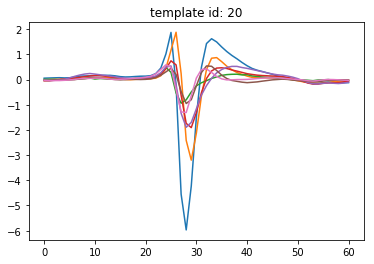

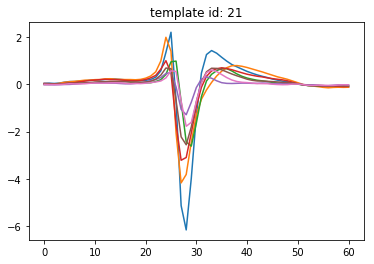

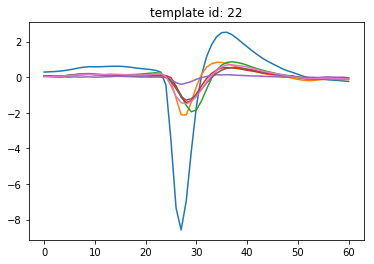

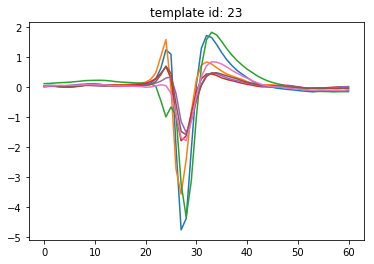

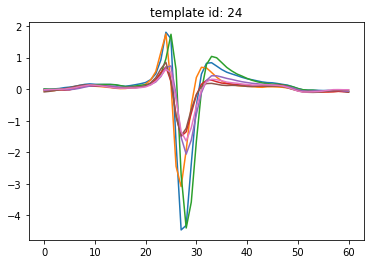

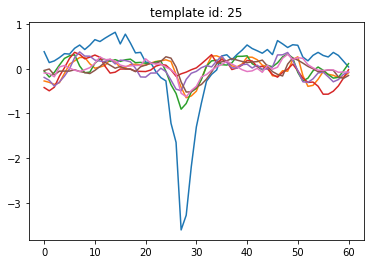

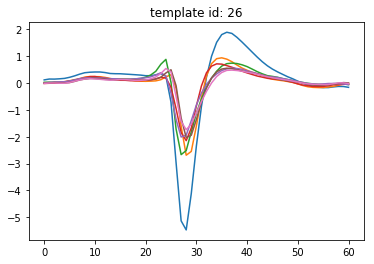

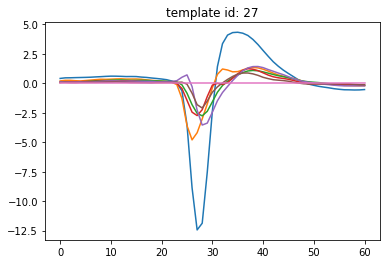

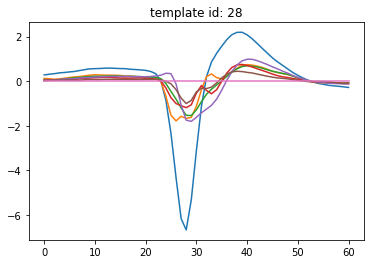

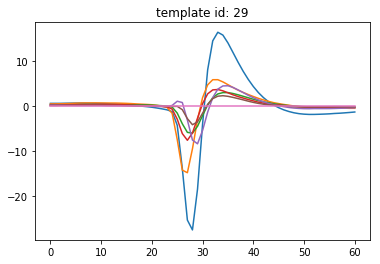

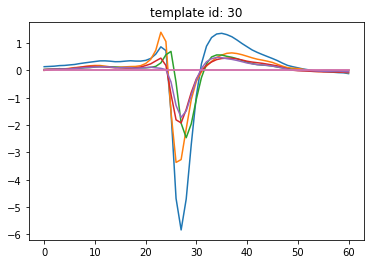

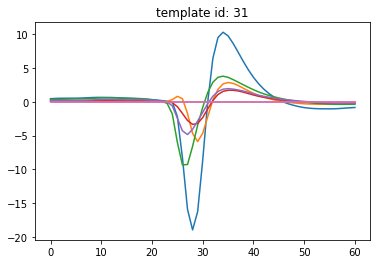

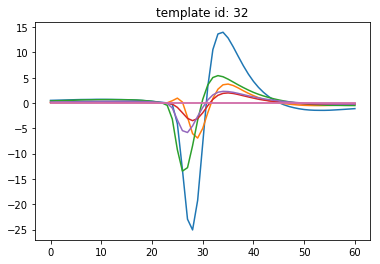

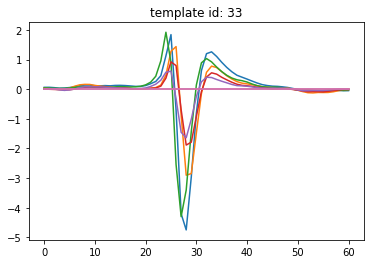

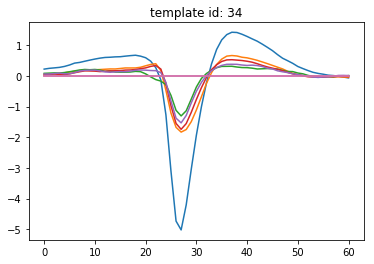

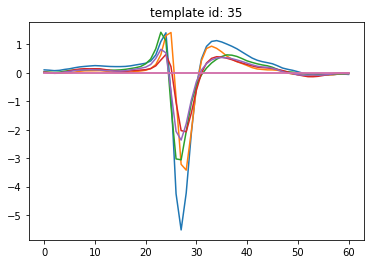

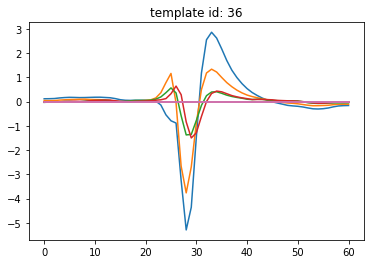

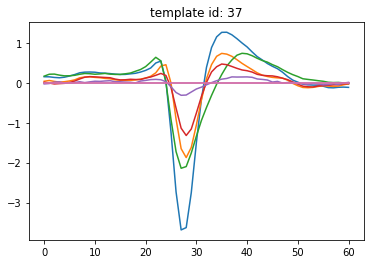

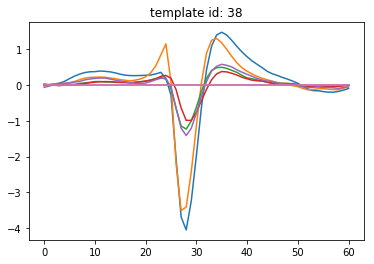

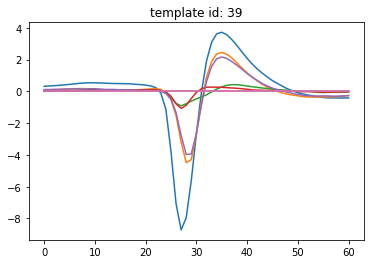

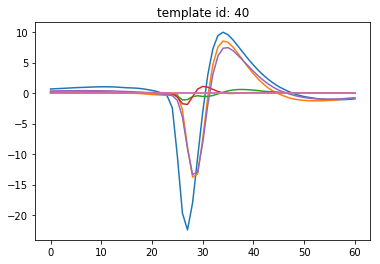

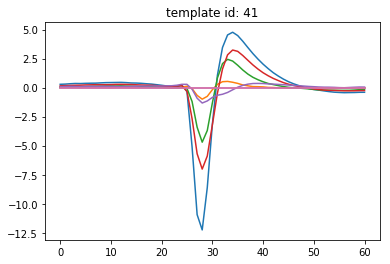

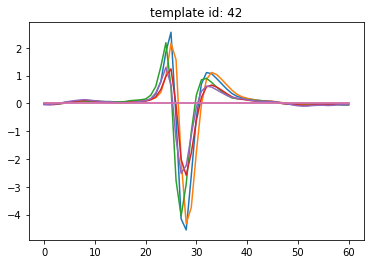

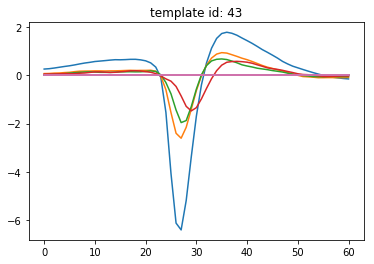

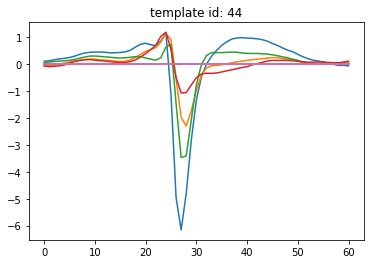

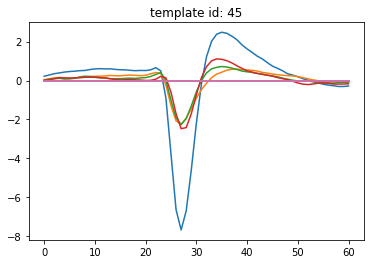

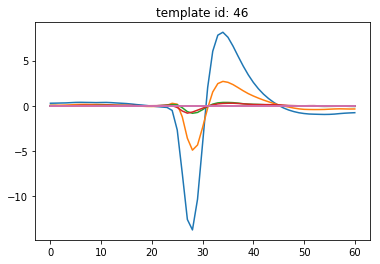

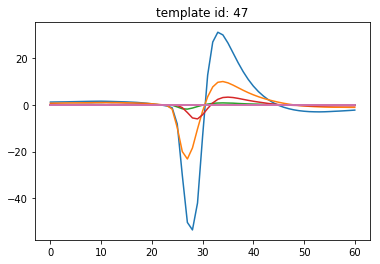

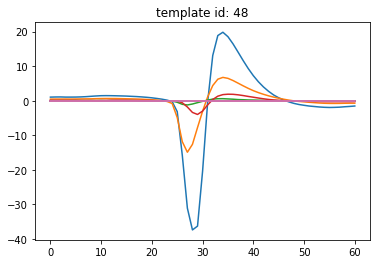

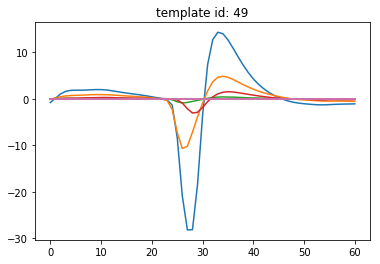

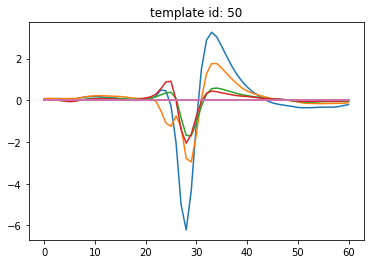

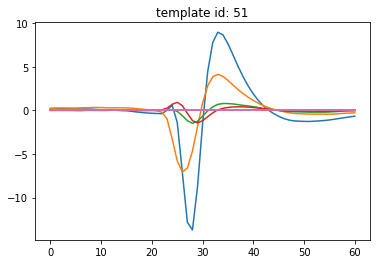

In [7]:
for i in range(templates.shape[0]):
    plt.plot(templates[i])
    plt.title('template id: %d'%(i))
    plt.show()

**Step 4: Make Training Dataset**

1. CONFIG and spike_train are from step 2 and 3.

2. chosen_templates: It is a vector containing which templates to use. Given spike sorting result, not all templates look good. Therefore, the training dataset should be obtained from good looking templates only. Make sure that you do not include bad templates. However, it is still important to keep variability in template shapes. To visually check templates, check optional step at the bottom.

3. min_amp: the minimum of absolute maximal amplitude of augmented spikes. It should determine how small spikes in the training set can be. Default is 3.

4. nspikes: approximately how many training data it should produce? This is the number of isolated spikes in the training set, NOT the total number of training datapoints 

5. noise_ratio,collision_ratio,misalign_ratio,misalign_ratio2: the ratio of the number of corresponding type of training data as opposed to the number of isolated spikes. For example, if noise_ratio=10, collision_ratio=1, misalign_ratio=3, misalign_ratio2=3; then for every portion of isolated data generated, 10 portions of noise data, 1 portion of collision data, 3 portions of spatially-and-temporally misaligned data (for x_detect), and 3 portions of spatially misaligned data(x_triage) will be generated. The proportion is to be customized according to the assumption of the distribution of the portions in real data. It is generally recommended that noise_ratio>=5 to reflect the sparse firing pattern of the neurons.

6. multi: boolean variable, if True (default), multi-channel data will be generated.



In [8]:
min_amp = 3
nspikes = 10000
data_folder = os.path.join(CONFIG.data.root_folder, 'tmp/preprocess') 
chosen_templates=np.arange(1,50) # should be your own numbers
np.delete(chosen_templates,[10, 20, 30])#getting rid of the bad-looking templates from Step 3.2
noise_ratio=10
collision_ratio=1
misalign_ratio=3
misalign_ratio2=3
multi=True

In [9]:
x_detect, y_detect, x_triage, y_triage, x_ae, y_ae = make_training_data(CONFIG,
                                                                        spike_train,
                                                                        chosen_templates,
                                                                        min_amp,
                                                                        nspikes,data_folder,
                                                                        noise_ratio,
                                                                        collision_ratio,
                                                                        misalign_ratio,
                                                                        misalign_ratio2,
                                                                        multi)

100%|██████████| 113/113 [00:04<00:00, 25.96it/s]


**Step 5: Train All Three Neural Networks**

Training parameters:
1. n_iter: the number of iterations to run
2. n_batch: the size of mini-batch to be used for training
3. l2_reg_scale: L2 regularization penalty term
4. train_step_size: training step size

In [10]:
# n_iter = 50000
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

Training neural net detector
1. detect_name: name of saved model with the location to save 
2. n_filters: number of filters to use in each layer. It should be a list of length 2

In [17]:
detectnet_name = './detectnet.ckpt'
n_filters_detect = [16, 8]

In [18]:
train_detector(x_detect, y_detect, n_filters_detect, n_iter, n_batch, l2_reg_scale, train_step_size, detectnet_name)

12502500it [10:06, 20628.34it/s] 

12502500it [06:52, 30303.01it/s] 


  0%|          | 0/5000 [00:00<?, ?it/s]


  0%|          | 1/5000 [00:00<43:30,  1.91it/s]


  3%|▎         | 171/5000 [00:00<29:26,  2.73it/s]


 11%|█         | 561/5000 [00:00<18:56,  3.90it/s]


 23%|██▎       | 1128/5000 [00:00<11:34,  5.58it/s]


 40%|████      | 2016/5000 [00:00<06:14,  7.96it/s]


 57%|█████▋    | 2850/5000 [00:01<03:09, 11.37it/s]


 82%|████████▏ | 4095/5000 [00:01<00:55, 16.24it/s]


5356it [00:01, 23.19it/s]                          


7260it [00:01, 33.10it/s]


9591it [00:01, 47.26it/s]


12090it [00:01, 67.46it/s]


14535it [00:01, 96.25it/s]


17391it [00:01, 137.30it/s]


20503it [00:01, 195.75it/s]


23005it [00:01, 278.69it/s]


26106it [00:02, 396.54it/s]


29403it [00:02, 563.57it/s]


32640it [00:02, 799.06it/s]


36315it [00:02, 1130.94it/s]


41041it [00:02, 1599.13it/s]


46665it [00:02, 2256.14it/s]


51360it [00:02, 3156.56it/s]


55945it [00:02, 4378.34it/s]


60726it [0

4778686it [00:20, 561344.82it/s]


4837605it [00:20, 551180.62it/s]


4893756it [00:20, 537375.09it/s]


4950231it [00:20, 508573.78it/s]


5003866it [00:20, 480007.27it/s]


5054610it [00:20, 442509.37it/s]


5102415it [00:20, 439416.05it/s]


5147236it [00:21, 437041.08it/s]


5192253it [00:21, 438450.50it/s]


5250420it [00:21, 471070.29it/s]


5299140it [00:21, 472899.76it/s]


5348085it [00:21, 462171.47it/s]


5397255it [00:21, 468066.78it/s]


5446650it [00:21, 473247.66it/s]


5496270it [00:21, 459420.51it/s]


5546115it [00:21, 466234.04it/s]


5596185it [00:21, 469528.33it/s]


5646480it [00:22, 471629.79it/s]


5717271it [00:22, 520019.07it/s]


5781700it [00:22, 548440.56it/s]


5839653it [00:22, 511632.21it/s]


5894461it [00:22, 511200.40it/s]


5963331it [00:22, 551108.68it/s]


6022185it [00:22, 536799.10it/s]


6077841it [00:22, 540960.76it/s]


6133753it [00:22, 533502.98it/s]


6189921it [00:23, 531529.41it/s]


6246345it [00:23, 517580.60it/s]


6310128it [00:23, 54

Approximate training true positive rate: 1.0, false positive rate: 0.0


In [19]:
# save model parameters
save_detect_network_params(filters = n_filters_detect,
                           size = x_detect.shape[1],
                           n_neighbors = x_detect.shape[2],
                           output_path = detectnet_name.replace('ckpt', 'yaml'))

Training neural net triage
1. triage_name: name of saved model with the location to save 
2. n_filters: number of filters to use in each layer. It should be a list of length 2

In [20]:
triagenet_name = './triagenet.ckpt'
n_filters_triage = [16, 8]

In [21]:
# run training
train_triage(x_triage, y_triage, n_filters_triage, n_iter, n_batch, l2_reg_scale, train_step_size, triagenet_name)




  0%|          | 0/5000 [00:00<?, ?it/s]


  0%|          | 1/5000 [00:00<50:34,  1.65it/s]


  9%|▊         | 435/5000 [00:00<32:19,  2.35it/s]


 30%|██▉       | 1485/5000 [00:00<17:25,  3.36it/s]


 66%|██████▋   | 3321/5000 [00:00<05:49,  4.80it/s]


5460it [00:01,  6.86it/s]                          


8778it [00:01,  9.80it/s]


12880it [00:01, 14.00it/s]


18528it [00:01, 19.99it/s]


24976it [00:01, 28.55it/s]


32896it [00:01, 40.79it/s]


41328it [00:01, 58.25it/s]


50086it [00:01, 83.20it/s]


57970it [00:01, 118.79it/s]


65341it [00:01, 169.59it/s]


74691it [00:02, 242.08it/s]


83845it [00:02, 345.42it/s]


92235it [00:02, 492.56it/s]


102831it [00:02, 702.19it/s]


112101it [00:02, 999.83it/s]


123256it [00:02, 1422.61it/s]


135460it [00:02, 2021.92it/s]


152628it [00:02, 2873.65it/s]


171405it [00:02, 4077.81it/s]


190036it [00:02, 5770.37it/s]


207046it [00:03, 8122.03it/s]


222778it [00:03, 11338.24it/s]


240471it [00:03, 15760.30it/s]


258840it [00:03,

Approximate training true positive rate: 0.9101123595505618, false positive rate: 0.04491725768321513


In [22]:
# save model parameters
save_triage_network_params(filters = n_filters_triage,
                           size = x_detect.shape[1],
                           n_neighbors = x_detect.shape[2],
                           output_path = triagenet_name.replace('ckpt', 'yaml'))

Training autoencoder
1. ae_name: name of saved model with the location to save 
2. n_feature: number of latent variables

In [25]:
ae_name = './ae.ckpt'
n_features = 3
n_batch = x_ae.shape[0]

In [26]:
# run training
train_ae(x_ae, y_ae, n_features, n_iter, n_batch, train_step_size, ae_name)

In [27]:
# save model parameters
save_ae_network_params(n_input = x_ae.shape[1],
                       n_features = n_features,
                       output_path = ae_name.replace('ckpt', 'yaml'))

**You are done!**

**Step 6: When Using yass**

Make sure that you have all your files! You must have **3 '.ckpt'** files and **1 '.yaml'** file for **each neural network model**, which make **total 12 files**.

Also, make sure that the parameters in your configuration file match with the parameters used during the training

| Name in config.yaml | How it should change |
|---|---|
|spikes.temporal_features|n_feature used for training autoencoder|
|recordings.spike_size_ms|make sure that this value stays the same as configuration loaded here|
|neural_network_detector.filename|file name used above to save neural net detector|
|neural_network_triage.filename|file name used above to save neural net triage|
|neural_network_autoencoder.filename|file name used above to save neural net autoencoder|